---

# Определение перспективного тарифа для телеком компании

---

<u>**Цель проекта**</u>: На основе данных клиентов оператора сотовой связи проанализировать поведение клиентов и поиск оптимального тарифа.

<u>**Сферы деятельности компаний**</u>: телеком.

<u>**Навыки и инструменты**</u>: Matplotlib, NumPy, Pandas, Python, SciPy, описательная статистика, проверка статистических гипотез.

## 1. Получение общей информации о предоставленных данных

In [1]:
import pandas as pd
import numpy as np
import math as m
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

Настроим параметры отображения графиков:

In [2]:
from pylab import rcParams
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
rcParams['figure.figsize'] = 8, 5

Можно также отключить предупреждения:

In [3]:
import warnings
warnings.simplefilter('ignore')

Прочитаем все пять доступных csv-файлов:

In [4]:
data_calls = pd.read_csv(...)
data_internet = pd.read_csv(...)
data_messages = pd.read_csv(...)
data_tariffs = pd.read_csv(...)
data_users = pd.read_csv(...)

Проверим данные на наличие **пропусков** и **дубликатов**:

In [5]:
if ((data_calls.duplicated().sum() == 0)
    & (data_messages.duplicated().sum() == 0)
    & (data_internet.duplicated().sum() == 0)
    & (data_users.duplicated().sum() == 0)
   ):
    print("Дубликаты отсутствуют!")
else:
    if data_calls.duplicated().sum() !=0:
        print('Дубликатов в data_calls:', data_calls.duplicated().sum())
    if data_messages.duplicated().sum() !=0:
        print('Дубликатов в data_messages:', data_messages.duplicated().sum())
    if data_internet.duplicated().sum() !=0:
        print('Дубликатов в data_internet:', data_internet.duplicated().sum())
    if data_users.duplicated().sum() !=0:
        print('Дубликатов в data_users:', data_users.duplicated().sum())

Дубликаты отсутствуют!


In [6]:
if ((data_calls.isna().sum().sum() == 0)
    & (data_messages.isna().sum().sum() == 0)
    & (data_internet.isna().sum().sum() == 0)
    & (data_users.isna().sum().sum() == 0)
   ):
    print("Пропуски отсутствуют!")
else:
    if data_calls.isna().sum().sum() !=0:
        print('Пропусков в data_calls:', data_calls.isna().sum().sum())
    if data_messages.isna().sum().sum() !=0:
        print('Пропусков в data_messages:', data_messages.isna().sum().sum())
    if data_internet.isna().sum().sum() !=0:
        print('Пропусков в data_internet:', data_internet.isna().sum().sum())
    if data_users.isna().sum().sum() !=0:
        print('Пропусков в data_users:', data_users.isna().sum().sum())

Пропусков в data_users: 462


In [7]:
data_users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Действительно, в *'churn_date'* **462 пропущенных значения**.

Согласно описанию данных, эти пропуски могут свидетельствовать о том, что на момент формирования датасетов контракты не были расторгнуты, поскольку в остальных ячейках находятся даты расторжения контрактов других пользователей.

Поэтому **поводов для беспокойства нет** — в дальнейшем для удобства **можно заменить пропуски "нулевыми" значениями**.

Внимательно изучим информацию о каждом наборе данных:

In [8]:
data_calls.info()
(
    data_calls
    .describe()
    .loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max'], ['duration']]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration
mean,6.755887
std,5.843365
min,0.000000
25%,1.300000
50%,6.000000
75%,10.700000
max,38.000000


**Потребуется замена типа данных:**

- *'id'*: "object" —> "int64"
- *'duration'*: "float64" —> "int64"

В столбце *'call_date'* необходимо **привести даты** к нормальному виду.

Сразу заметно **большое количество коротких звонков** — требуется детально изучить распределение звонков по длительности. Длительность звонков при расчётах, согласно условиям предоставления услуг, округляется в большую сторону. Поэтому возможны два варианта:
    <ol>
        <li> Можно исключить все звонки с нулевой продолжительностью, если их наличие обусловлено ошибками при формировании датасета; </li>
        <li> Приравнять длительность всех "нулевых" звонков к одной минуте, если "нули" получены округлением длительностей звонков в сторону ближайшего целого. </li>
    </ol>
    <b> Ошибки в данных связаны, скорее всего, с округлением звонков до ближайшего, а не до большего целого. По этой причине все звонки длительностью менее 30 секунд были округлены до нуля. </b>

In [9]:
data_internet.info()
(
    data_internet
    .describe()
    .loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max'], ['mb_used']]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,mb_used
mean,370.192426
std,278.300951
min,0.000000
25%,138.187500
50%,348.015000
75%,559.552500
max,1724.830000


Присутствует столбец *'Unnamed: 0'*, предназначение которого пока неизвестно. Выясним, что это за столбец, и что в нём содержится:

In [10]:
data_internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
47717,47717,1164_286,185.79,2018-08-30,1164
38723,38723,1135_203,220.02,2018-11-28,1135
8475,8475,1029_127,456.51,2018-10-01,1029
30249,30249,1106_51,52.89,2018-09-13,1106
77846,77846,1262_498,218.95,2018-03-27,1262
5566,5566,1017_6,518.94,2018-11-11,1017
88750,88750,1300_122,140.11,2018-08-13,1300
112931,112931,1381_520,531.11,2018-07-15,1381
11200,11200,1039_111,488.64,2018-10-21,1039
75361,75361,1253_100,546.56,2018-11-25,1253


В *'Unnamed: 0'* находятся продублированные, а потому ненужные в дальнейшем, индексы. **Удалим** столбец.

In [11]:
data_internet.columns.tolist()

['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id']

In [12]:
data_internet = data_internet[['id', 'mb_used', 'session_date', 'user_id']]
data_internet.sample(10)

,id,mb_used,session_date,user_id
1789,1006_420,435.15,2018-04-07,1006
130563,1435_171,428.86,2018-03-13,1435
116420,1392_163,870.85,2018-08-12,1392
115868,1391_1,343.11,2018-10-21,1391
80790,1272_182,285.66,2018-10-11,1272
131953,1439_70,24.26,2018-09-15,1439
114162,1385_370,1021.24,2018-01-17,1385
43566,1149_566,35.06,2018-05-30,1149
3343,1011_210,624.95,2018-05-25,1011
140935,1472_609,180.04,2018-06-10,1472


**Потребуется замена типа данных:**

- *'id'*: "object" —> "int64"

В столбце *'session_date'* необходимо **привести даты** к нормальному виду.

In [13]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
data_messages.sample(10)

,id,message_date,user_id
61385,1270_258,2018-08-14,1270
12026,1052_98,2018-11-14,1052
52212,1231_833,2018-12-03,1231
111785,1452_174,2018-10-15,1452
86407,1358_36,2018-05-30,1358
71680,1302_508,2018-12-28,1302
7869,1032_40,2018-04-15,1032
102176,1417_38,2018-09-25,1417
23642,1097_157,2018-12-15,1097
54643,1243_341,2018-12-24,1243


**Потребуется замена типа данных:**

- *'id'*: "object" —> "int64"

В столбце *'message_date'* необходимо **привести даты** к нормальному виду.

In [15]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Предобработка данного датасета не требуется.**

In [17]:
data_users.info()
(
    data_users
    .describe()
    .loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max'], ['age']]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,age
mean,46.58800
std,16.66763
min,18.00000
25%,32.00000
50%,46.00000
75%,62.00000
max,75.00000


В столбце *'reg_date'* необходимо **привести даты** к нормальному виду.

In [18]:
(sorted(
    data_users['city']
        .unique()
        .tolist()
))

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

Порядок.

**Названия городов готовы к работе.**

In [19]:
(sorted(
    data_users['first_name']
    .unique()
    .tolist()
))

['Авксентий',
 'Агата',
 'Агафья',
 'Агнесса',
 'Адам',
 'Аким',
 'Аксён',
 'Алан',
 'Алевтина',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алла',
 'Альберта',
 'Альбин',
 'Альфред',
 'Алёна',
 'Анатолий',
 'Анвар',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анита',
 'Антонина',
 'Анфиса',
 'Арина',
 'Арнольд',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артём',
 'Аурелия',
 'Афанасий',
 'Ахмет',
 'Аюна',
 'Белла',
 'Берта',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Варлам',
 'Василиса',
 'Вениамин',
 'Вера',
 'Вероника',
 'Веселина',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Габриель',
 'Габриэль',
 'Гайдар',
 'Галина',
 'Гарри',
 'Гектор',
 'Гелена',
 'Геннадий',
 'Геодар',
 'Георгий',
 'Георгина',
 'Геральд',
 'Герасим',
 'Глеб',
 'Гордей',
 'Григорий',
 'Дайна',
 'Дана',
 'Даниил',
 'Даниэла',
 'Дебора',
 'Демьян',
 'Денис',
 'Джемма',
 'Джозефина',
 'Джулия',
 'Динара',
 'Доминика

Здесь тоже полный порядок, если не обращать внимания на обилие редких, а местами даже архаичных имён юзеров.
"А" — анонимность.

**Имена клиентов готовы к работе.**

In [20]:
(sorted(
    data_users['last_name']
    .unique()
    .tolist()
))

['Ёлчина',
 'Ёркин',
 'Ёркина',
 'Ёрохов',
 'Ёрохова',
 'Абаимов',
 'Абакумов',
 'Абакшина',
 'Абалакова',
 'Абалдуева',
 'Абалкин',
 'Абашкин',
 'Абашкина',
 'Абдулина',
 'Абоимов',
 'Абрамович',
 'Абрамцев',
 'Абрамычева',
 'Абрашина',
 'Абрикосова',
 'Авдеев',
 'Авдеенко',
 'Авдонюшкин',
 'Авдушева',
 'Авдышев',
 'Авдюков',
 'Авраамова',
 'Авраменко',
 'Авринский',
 'Аврорин',
 'Авроров',
 'Авросимова',
 'Авросинова',
 'Авсейкина',
 'Авчинникова',
 'Агаев',
 'Агаева',
 'Агапеева',
 'Агеева',
 'Адаменко',
 'Адамов',
 'Азаров',
 'Азерников',
 'Азимова',
 'Акимов',
 'Акимчин',
 'Акимычева',
 'Акиндинов',
 'Акинин',
 'Акинфьев',
 'Аксёнов',
 'Акуленко',
 'Александрова',
 'Александрович',
 'Александрюк',
 'Алексеева',
 'Алексеенко',
 'Алексеичев',
 'Аленникова',
 'Алесин',
 'Алехина',
 'Алешин',
 'Алешина',
 'Алешкова',
 'Алиев',
 'Алфеева',
 'Алфимов',
 'Алфимова',
 'Алымова',
 'Алютин',
 'Алюшина',
 'Алёшко',
 'Алёшкова',
 'Амелин',
 'Амелишко',
 'Амельченко',
 'Ананьева',
 'Андреенко'

**Фамилии клиентов готовы к работе.**

In [21]:
data_users['tariff'].nunique()

2

В столбцах *'churn_date'* и *'reg_date'* необходимо **привести даты** к нормальному виду.

## Вывод:

Прочитаны CSV-файлы **"data_calls"**, **"data_internet"**, **"data_messages"**, **"data_tariffs"** и **"data_users"**.

**Дубликаты отсутствуют**.

В столбце *'churn_date'* датафрейма "data_users" **462 пропущенных значения**, расположенные в строках с информацией о пользователях, **контракты которых на момент формирования датасетов были действительными**. 

Столбец *'id'* во всех датафреймах, его содержащих, требует **смены типа** на "int64". То же самое предстоит сделать с *'duration'* из "data_calls".

Необходимо **привести даты** к "datetime64" в *'call_date'* из "data_calls", *'session_date'* из "data_internet", а также *'message_date'* и *'reg_date'* из "data_messages".

Требует внимания **большое количество коротких звонков**.

## 2. Предобработка данных

Начнём с **data_calls**. Столбцы *'id'* и *'duration'* должны содержать данные типа ***int64***, а *'call_date'* — ***datetime64***:

In [22]:
data_calls['id'] = data_calls['id'].astype(np.int64)
data_calls['duration'] = data_calls['duration'].astype(np.int64)
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')

Взглянем на результаты преобразований:

In [23]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


In [24]:
(print('Доля звонков с нулевой продолжительностью: {:.2%}'
      .format(data_calls
              .query('duration == 0')
              ['duration']
              .count()
              /
             data_calls
              ['duration']
              .count()))
)

Доля звонков с нулевой продолжительностью: 23.66%


In [25]:
data_calls.query('duration == 0').sample(10)

,id,call_date,duration,user_id
164877,1408126,2018-07-09,0,1408
150164,13771011,2018-12-23,0,1377
168228,1414348,2018-09-20,0,1414
61316,1155124,2018-12-07,0,1155
89220,1224137,2018-11-03,0,1224
15088,104087,2018-10-26,0,1040
153196,138171,2018-12-07,0,1381
59224,1148687,2018-07-18,0,1148
53102,1134163,2018-08-13,0,1134
190156,1468127,2018-04-15,0,1468


Звонки с нулевой продолжительностью несколько смещают среднее выборки влево и искажают общую картину. Поскольку в описании кейса сказано, что проблема в самих данных, а по образцу датасета видно, что все остальные столбцы информативны, пойдём по второму из ранее предусмотренных вариантов — **примем длительность всех "нулевых" звонков за единицу**:

In [26]:
data_calls['duration'].head(10)

0     0
1     0
2     2
3    13
4     5
5     0
6     0
7    18
8    18
9     0
Name: duration, dtype: int64

In [27]:
data_calls['duration'] = np.ceil(data_calls['duration']).replace(0, 1).astype(np.int64)

In [28]:
(data_calls
 .describe()
 .loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max'],
      ['duration']]
)

,duration
mean,6.597901
std,5.483258
min,1.000000
25%,1.000000
50%,6.000000
75%,10.000000
max,38.000000


Так лучше. Поработаем над типами данных: 

In [29]:
data_internet['id'] = data_internet['id'].astype(np.int64)
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

In [30]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int64         
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.6 MB


Не забудем об округлении использованного трафика в мегабайтах **в сторону большего целого** в соответствии с условиями предоставления услуг компании:

In [31]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype(np.int64)
data_internet.sample(5)

,id,mb_used,session_date,user_id
82611,1280224,387,2018-09-09,1280
136548,1457390,833,2018-05-07,1457
91648,1310109,945,2018-08-03,1310
120879,1408187,281,2018-11-11,1408
82543,1280156,21,2018-07-23,1280


Данные в столбце *'id'* приведём к типу **int64**, а в *'message_date'* — к типу **datetime64**:

In [32]:
data_messages['id'] = data_internet['id'].astype(np.int64)
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

In [33]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


Данные в столбце *'user_id'* приведём к типу **int64**, а в столбцах *'reg_date'* и *'churn_date'* — к типу **datetime64**:

In [34]:
data_users['user_id'] = data_users['user_id'].astype(np.int64)
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

In [35]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Вывод:

На этапе предобработки с данными были проделаны следующие манипуляции:

- [X] data_calls:
   - [X] *'id'*: "object" —> "int64"
   - [X] *'duration'*: "float64" —> "int64"
   - [X] *'call_date'*: "object" —> "datetime64"
- [X] data_internet:
   - [X] *'id'*: "object" —> "int64"
   - [X] *'session_date'*: "object" —> "datetime64"
- [X] data_messages:
   - [X] *'id'*: "object" —> "int64"
   - [X] *'message_date'*: "object" —> "datetime64"
- [X] data_tariffs
- [X] data_users:
   - [X] *'churn_date'*: "object" —> "datetime64"
   - [X] *'reg_date'*: "object" —> "datetime64"

Новые типы данных позволяют приступить к анализу. Предстоит дополнить датафреймы новыми стоблцами, облегчающими поиск ответов на поставленные вопросы. Имена столбцов для удобства желательно поменять.

## 3. Анализ данных

Первоочередная задача — **категоризация статистики использования услуг компании по временным интервалам**.

В рамках поставленной задачи нас интересуют **расчётные месяцы**. Добавим их в соответствующие датафреймы, проверим количество месяцев в каждом из наборов данных:

In [36]:
#Добавим к каждому датафрейму столбец с цифрами от 1 до 12, обозначающими месяцы:
data_calls['calls_month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_internet['internet_month'] = pd.DatetimeIndex(data_internet['session_date']).month
data_messages['messages_month'] = pd.DatetimeIndex(data_messages['message_date']).month

#Если спектр значений всех трёх новых столбцов одинаков, выведем их на экран вместе:
if (sorted(data_calls['calls_month'].unique().tolist())
    == sorted(data_internet['internet_month'].unique().tolist())
    == sorted(data_messages['messages_month'].unique().tolist())):
    print("Номера месяцев, за которые имеются данные о совершённых клиентами звонках, об отправленных сообщениях,")
    print("а также об интернет-трафике:", sorted(data_calls['calls_month'].unique().tolist()))
#В противном случае выведем на экран значения, присутствующие в столбцах, по отдельности:    
else:
    print(
        'Номера месяцев, за которые имеются данные о совершённых клиентами звонках:',
        sorted(
            data_calls['calls_month']
            .unique()
            .tolist()
        )
    )
    print(
        'Номера месяцев, за которые имеются данные об интернет-трафике:',
        sorted(
            data_internet['internet_month']
            .unique()
            .tolist()
        )
    )
    print(
        'Номера месяцев, за которые имеются данные о сообщениях:',
        sorted(
            data_messages['messages_month']
            .unique()
            .tolist()
        )
    )


Номера месяцев, за которые имеются данные о совершённых клиентами звонках, об отправленных сообщениях,
а также об интернет-трафике: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [37]:
gbl = globals()

data_merged = data_users[['user_id']]

for i in range(12):
    
    i += 1


    gbl['calls_count_'+str(i)] = (data_calls[data_calls['calls_month'] == i]
                                  .pivot_table(index='user_id', values='call_date', aggfunc='count')
                                 )

    gbl['data_calls_'+str(i)] = (data_calls[data_calls['calls_month'] == i]
                                 .pivot_table(index='user_id',
                                              values='duration',
                                              aggfunc='sum')
                                 .merge(gbl['calls_count_'+str(i)],
                                          on='user_id',
                                          how='outer')
                                )
                                      
    gbl['data_calls_'+str(i)].columns = ['duration', 'calls_count']
    
    gbl['data_internet_'+str(i)] = (data_internet
                                    [data_internet['internet_month'] == i]
                                    .pivot_table(index='user_id',
                                              values='mb_used',
                                              aggfunc='sum')
                                   )
    
    gbl['data_messages_'+str(i)] = (data_messages
                                    [data_messages['messages_month'] == i]
                                    [data_internet['internet_month'] == i]
                                    .pivot_table(index='user_id',
                                              values='id',
                                              aggfunc='count')
                                   )

    gbl['data_merged_'+str(i)] = ( gbl['data_calls_'+str(i)]
                                  .merge(gbl['data_internet_'+str(i)],
                                         on='user_id',
                                         how='outer')
                                  .merge(gbl['data_messages_'+str(i)],
                                         on='user_id',
                                         how='outer')
                                  .merge(data_users,
                                         on='user_id',
                                         how='left')
                                  .fillna(0)
                                 )
    
    gbl['data_merged_'+str(i)] = (gbl['data_merged_'+str(i)][['user_id',
                                                             'duration',
                                                             'calls_count',
                                                             'mb_used',
                                                             'id',
                                                             'city',
                                                             'tariff']])
    

    gbl['data_merged_'+str(i)].columns = ['user_id',
                                          ('total_calls_duration_'+str(i)),
                                          ('total_calls_count_'+str(i)),
                                          ('total_mb_used_'+str(i)),
                                          ('total_messages_'+str(i)),
                                          'city',
                                          'tariff']
    
    data_merged = (data_merged
                   .merge(gbl['data_merged_'+str(i)]
                          [['user_id',
                            ('total_calls_duration_'+str(i)),
                            ('total_calls_count_'+str(i)),
                            ('total_mb_used_'+str(i)),
                            ('total_messages_'+str(i))]],
                         on='user_id',
                         how='outer')
                   .fillna(0)
                   )


In [38]:
#Введём условно "бесконечно малую" переменную "inf" (от англ. "infinitesimal"):
inf = 0.0000000001

#Если в текущем месяце пользователь был активен, число месяцев активности увеличится (почти) на единицу.
#Месяцы без активности не повлияют на общую сумму.
#Таким образом, в дальнейшем нам не придётся думать о том, по каким месяцам на данного пользователя
#имеется статистика, а по каким отсутствует.
data_merged['activity_months'] = ((data_merged['total_calls_duration_1']
                                   /(data_merged['total_calls_duration_1'] + inf)
                                  + data_merged['total_calls_duration_2']
                                   /(data_merged['total_calls_duration_2'] + inf)
                                  + data_merged['total_calls_duration_3']
                                   /(data_merged['total_calls_duration_3'] + inf)
                                  + data_merged['total_calls_duration_4']
                                   /(data_merged['total_calls_duration_4'] + inf)
                                  + data_merged['total_calls_duration_5']
                                   /(data_merged['total_calls_duration_5'] + inf)
                                  + data_merged['total_calls_duration_6']
                                   /(data_merged['total_calls_duration_6'] + inf)
                                  + data_merged['total_calls_duration_7']
                                   /(data_merged['total_calls_duration_7'] + inf)
                                  + data_merged['total_calls_duration_8']
                                   /(data_merged['total_calls_duration_8'] + inf)
                                  + data_merged['total_calls_duration_9']
                                   /(data_merged['total_calls_duration_9'] + inf)
                                  + data_merged['total_calls_duration_10']
                                   /(data_merged['total_calls_duration_10'] + inf)
                                  + data_merged['total_calls_duration_11']
                                   /(data_merged['total_calls_duration_11'] + inf)
                                  + data_merged['total_calls_duration_12']
                                   /(data_merged['total_calls_duration_12'] + inf)
                                  )
                                 )

#Округлим до большего целого:
data_merged['activity_months'] = np.ceil(data_merged['activity_months'])

In [39]:
#Найдём среднемесячную продолжительность звонков для каждого пользователя
# с учётом числа расчётных периодов, в которые он был активен:
data_merged['monthly_calls_duration'] = ((data_merged['total_calls_duration_1']
                                         + data_merged['total_calls_duration_2']
                                         + data_merged['total_calls_duration_3']
                                         + data_merged['total_calls_duration_4']
                                         + data_merged['total_calls_duration_5']
                                         + data_merged['total_calls_duration_6']
                                         + data_merged['total_calls_duration_7']
                                         + data_merged['total_calls_duration_8']
                                         + data_merged['total_calls_duration_9']
                                         + data_merged['total_calls_duration_10']
                                         + data_merged['total_calls_duration_11']
                                         + data_merged['total_calls_duration_12']
                                         )/data_merged['activity_months']
                                        )

#Те же операции проделаем с интернет-траффиком и сообщениями:
data_merged['monthly_internet_mb'] = ((data_merged['total_mb_used_1']
                                         + data_merged['total_mb_used_2']
                                         + data_merged['total_mb_used_3']
                                         + data_merged['total_mb_used_4']
                                         + data_merged['total_mb_used_5']
                                         + data_merged['total_mb_used_6']
                                         + data_merged['total_mb_used_7']
                                         + data_merged['total_mb_used_8']
                                         + data_merged['total_mb_used_9']
                                         + data_merged['total_mb_used_10']
                                         + data_merged['total_mb_used_11']
                                         + data_merged['total_mb_used_12']
                                         )/data_merged['activity_months']
                                        )

data_merged['monthly_messages_count'] = ((data_merged['total_messages_1']
                                         + data_merged['total_messages_2']
                                         + data_merged['total_messages_3']
                                         + data_merged['total_messages_4']
                                         + data_merged['total_messages_5']
                                         + data_merged['total_messages_6']
                                         + data_merged['total_messages_7']
                                         + data_merged['total_messages_8']
                                         + data_merged['total_messages_9']
                                         + data_merged['total_messages_10']
                                         + data_merged['total_messages_11']
                                         + data_merged['total_messages_12']
                                         )/data_merged['activity_months']
                                        )

In [40]:
#Из всех столбцов, которые в настоящее время присутствуют в "data_merged", нам понадобятся только 5.
#Выполним слияние оставшихся столбцов со столбцами датафрейма "data_users".
#В первую очередь нам интересны тарифы и населённые пункты:
data_merged = (data_merged[['user_id',
                         'activity_months',
                         'monthly_calls_duration',
                         'monthly_internet_mb',
                         'monthly_messages_count']]
               .merge(data_users,
                      on='user_id',
                      how='outer'
                     )[['user_id',
                         'activity_months',
                         'monthly_calls_duration',
                         'monthly_internet_mb',
                         'monthly_messages_count',
                         'city',
                         'tariff']]
              )

#Выкинем 8 строк, содержащих пропуски:
data_merged = data_merged.dropna().reset_index(drop=True)


In [41]:

#Вычтем установленные тарифами лимиты, чтобы узнать минуты, сообщения и мегабайты сверх тарифов:
data_merged['extra_monthly_calls_duration'] = data_merged['monthly_calls_duration']
data_merged['extra_monthly_internet_mb'] = data_merged['monthly_internet_mb']
data_merged['extra_monthly_messages_count'] = data_merged['monthly_messages_count']

(data_merged.loc[data_merged['tariff'] == 'smart',
                 'extra_monthly_calls_duration']) -= data_tariffs['minutes_included'][0]
(data_merged.loc[data_merged['tariff'] == 'smart',
                 'extra_monthly_internet_mb']) -= data_tariffs['mb_per_month_included'][0]
(data_merged.loc[data_merged['tariff'] == 'smart',
                 'extra_monthly_messages_count']) -= data_tariffs['messages_included'][0]

(data_merged.loc[data_merged['tariff'] == 'ultra',
                 'extra_monthly_calls_duration']) -= data_tariffs['minutes_included'][1]
(data_merged.loc[data_merged['tariff'] == 'ultra',
                 'extra_monthly_internet_mb']) -= data_tariffs['mb_per_month_included'][1]
(data_merged.loc[data_merged['tariff'] == 'ultra',
                 'extra_monthly_messages_count']) -= data_tariffs['messages_included'][1]

#Отрицательные величины заменим нулями:
data_merged['extra_monthly_calls_duration'] = (np.where(data_merged
                                                  ['extra_monthly_calls_duration'] < 0,
                                                  0,
                                                  data_merged['extra_monthly_calls_duration']
                                                 )
                                        )
data_merged['extra_monthly_internet_mb'] = (np.where(data_merged
                                               ['extra_monthly_internet_mb'] < 0,
                                               0,
                                               data_merged['extra_monthly_internet_mb']
                                              )
                                     )
data_merged['extra_monthly_messages_count'] = (np.where(data_merged
                                                  ['extra_monthly_messages_count'] < 0,
                                                  0,
                                                  data_merged['extra_monthly_messages_count']
                                                 )
                                        )


#Посчитаем ежемесячную выручку для пользователей каждого из двух тарифов:
(data_merged.loc[data_merged['tariff'] == 'smart',
                 'monthly_revenue']) = (data_tariffs['rub_monthly_fee'][0]
 + data_merged
 .loc[data_merged['tariff'] == 'smart', 'extra_monthly_calls_duration']
 *data_tariffs['rub_per_minute'][0]
 + data_merged
 .loc[data_merged['tariff'] == 'smart', 'extra_monthly_internet_mb']
 *data_tariffs['rub_per_gb'][0]/1024
 + data_merged
 .loc[data_merged['tariff'] == 'smart', 'extra_monthly_messages_count']
 *data_tariffs['rub_per_message'][0])


(data_merged.loc[data_merged['tariff'] == 'ultra',
                 'monthly_revenue']) =  (data_tariffs['rub_monthly_fee'][1]
 + data_merged
 .loc[data_merged['tariff'] == 'ultra', 'extra_monthly_calls_duration']
 *data_tariffs['rub_per_minute'][1]
 + data_merged
 .loc[data_merged['tariff'] == 'ultra', 'extra_monthly_internet_mb']
 *data_tariffs['rub_per_gb'][1]/1024
 + data_merged
 .loc[data_merged['tariff'] == 'ultra', 'extra_monthly_messages_count']
 *data_tariffs['rub_per_message'][1])

In [42]:
data_merged = data_merged [['user_id',
                            'tariff',
                            'activity_months',
                            'monthly_calls_duration',
                            'monthly_internet_mb',
                            'monthly_messages_count',
                            'monthly_revenue',
                            'city']
                          ]

In [43]:
data_merged

,user_id,tariff,activity_months,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue,city
0,1000,ultra,8.0,295.375000,13436.500000,9.250000,1950.000000,Краснодар
1,1001,smart,2.0,393.500000,16252.500000,0.000000,724.316406,Москва
2,1002,smart,7.0,200.428571,16597.571429,1.428571,791.713170,Стерлитамак
3,1003,ultra,5.0,702.800000,11465.800000,13.400000,1950.000000,Москва
4,1004,ultra,8.0,111.500000,18646.500000,14.375000,1950.000000,Новокузнецк
...,...,...,...,...,...,...,...,...
487,1495,ultra,5.0,717.600000,25507.200000,14.000000,1950.000000,Иркутск
488,1496,smart,12.0,459.333333,22605.750000,3.666667,1965.185547,Вологда
489,1497,smart,3.0,433.333333,15208.666667,4.666667,550.000000,Челябинск
490,1498,smart,4.0,296.750000,18631.500000,8.750000,1188.964844,Владикавказ


Приступим к **статистическому анализу**.

In [44]:
data_merged[['monthly_calls_duration',
             'monthly_internet_mb',
             'monthly_messages_count',
             'monthly_revenue']].describe()

,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue
count,492.000000,492.000000,492.000000,492.000000
mean,421.577978,17173.995460,4.972556,1263.121669
std,181.101659,5619.156735,5.999272,622.961019
min,9.714286,0.000000,0.000000,550.000000
25%,296.562500,13903.674603,1.000000,595.090909
50%,411.013889,16690.291667,3.500000,1170.299479
75%,514.750000,19563.580357,6.517857,1950.000000
max,1086.636364,38502.000000,43.000000,3089.941406


In [45]:
data_merged

,user_id,tariff,activity_months,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue,city
0,1000,ultra,8.0,295.375000,13436.500000,9.250000,1950.000000,Краснодар
1,1001,smart,2.0,393.500000,16252.500000,0.000000,724.316406,Москва
2,1002,smart,7.0,200.428571,16597.571429,1.428571,791.713170,Стерлитамак
3,1003,ultra,5.0,702.800000,11465.800000,13.400000,1950.000000,Москва
4,1004,ultra,8.0,111.500000,18646.500000,14.375000,1950.000000,Новокузнецк
...,...,...,...,...,...,...,...,...
487,1495,ultra,5.0,717.600000,25507.200000,14.000000,1950.000000,Иркутск
488,1496,smart,12.0,459.333333,22605.750000,3.666667,1965.185547,Вологда
489,1497,smart,3.0,433.333333,15208.666667,4.666667,550.000000,Челябинск
490,1498,smart,4.0,296.750000,18631.500000,8.750000,1188.964844,Владикавказ


Для каждого тарифа посчитаем **математические ожидания**, **медианы**, **дисперсии** и **стандартные отклонения**:

In [46]:
columns = ['tariff',
           
           'calls_mean',
           'mb_mean',
           'messages_mean',
           
           'calls_median',
           'mb_median',
           'messages_median',
           
           'calls_var',
           'mb_var',
           'messages_var',
           
           'calls_std',
           'mb_std',
           'messages_std'       
          ]
data = []

for i in ['smart', 'ultra']:
    data.append([str(i),
                 data_merged.query('tariff == @i')['monthly_calls_duration'].mean(),
                 data_merged.query('tariff == @i')['monthly_internet_mb'].mean(),
                 data_merged.query('tariff == @i')['monthly_messages_count'].mean(),
                 
                 data_merged.query('tariff == @i')['monthly_calls_duration'].median(),
                 data_merged.query('tariff == @i')['monthly_internet_mb'].median(),
                 data_merged.query('tariff == @i')['monthly_messages_count'].median(),
                 
                 np.var(data_merged.query('tariff == @i')['monthly_calls_duration']),
                 np.var(data_merged.query('tariff == @i')['monthly_internet_mb']),
                 np.var(data_merged.query('tariff == @i')['monthly_messages_count']),
                 
                 np.std(data_merged.query('tariff == @i')['monthly_calls_duration']),
                 np.var(data_merged.query('tariff == @i')['monthly_internet_mb']),
                 np.var(data_merged.query('tariff == @i')['monthly_messages_count']),
                ]
               )

In [47]:
data_statistics = pd.DataFrame(data=data, columns=columns)
data_statistics

,tariff,calls_mean,mb_mean,messages_mean,calls_median,mb_median,messages_median,calls_var,mb_var,messages_var,calls_std,mb_std,messages_std
0,smart,387.958231,16205.515926,4.177079,393.500,16268.714286,3.0,17438.703584,1.288678e+07,26.095689,132.055684,1.288678e+07,26.095689
1,ultra,503.628970,19537.627330,6.913965,482.125,18803.625000,5.1,60562.370841,6.908775e+07,54.576885,246.094232,6.908775e+07,54.576885


Создадим и призовём на защиту русского языка <b>функции автоматической адаптации слов</b> "минута", "сообщение" и "рубль" к стоящим перед ними числительным:

In [48]:
def minutes_number(minutes):
    minutes = int(minutes)
    minutes_ending = ['минута', 'минуты', 'минут']
    if minutes % 10 == 1 and minutes % 100 != 11:
        p = 0
    elif 2 <= minutes % 10 <= 4 and (minutes % 100 < 10 or minutes % 100 >= 20):
        p = 1
    else:
        p = 2
    return str(minutes) + ' ' + minutes_ending[p]

def messages_number(messages):
    messages = int(messages)
    messages_ending = ['сообщение', 'сообщения', 'сообщений']
    if messages % 10 == 1 and messages % 100 != 11:
        p = 0
    elif 2 <= messages % 10 <= 4 and (messages % 100 < 10 or messages % 100 >= 20):
        p = 1
    else:
        p = 2
    return str(messages) + ' ' + messages_ending[p]

def rubles_number(rubles):
    rubles = int(rubles)
    rubles_ending = ['рубль', 'рубля', 'рублей']
    if rubles % 10 == 1 and rubles % 100 != 11:
        p = 0
    elif 2 <= rubles % 10 <= 4 and (rubles % 100 < 10 or rubles % 100 >= 20):
        p = 1
    else:
        p = 2
    return str(rubles) + ' ' + rubles_ending[p]

In [49]:
print('Пользователям тарифа "Smart" требуется {}, {} и {} ГБ интернет-трафика;'
     .format(minutes_number(data_statistics['calls_median'][0]),
             messages_number(data_statistics['messages_median'][0]),
             int(data_statistics['mb_median'][0]/1024)
            )
     )
print('Пользователям тарифа "Ultra" требуется {}, {} и {} ГБ интернет-трафика.'
     .format(minutes_number(data_statistics['calls_median'][1]),
             messages_number(data_statistics['messages_median'][1]),
             int(data_statistics['mb_median'][1]/1024)
            )
     )

Пользователям тарифа "Smart" требуется 393 минуты, 3 сообщения и 15 ГБ интернет-трафика;
Пользователям тарифа "Ultra" требуется 482 минуты, 5 сообщений и 18 ГБ интернет-трафика.


Построим гистограммы распределения среднемесячных количеств звонков, сообщений и интернет-трафика.

In [50]:
data_merged_smart = data_merged.query('tariff == "smart"')
data_merged_ultra = data_merged.query('tariff == "ultra"')

Качество визуализации данных будет напрямую зависеть от числа корзин на гистограммах.
  
Воспользуемся **правилом Стёрджеса**:

In [51]:
bins_count_smart = (int(1 + m.log2(data_merged_smart['user_id'].count())))
bins_count_ultra = (int(1 + m.log2(data_merged_ultra['user_id'].count())))

In [52]:
data_merged_smart

,user_id,tariff,activity_months,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue,city
1,1001,smart,2.0,393.500000,16252.500000,0.000000,724.316406,Москва
2,1002,smart,7.0,200.428571,16597.571429,1.428571,791.713170,Стерлитамак
5,1005,smart,12.0,508.166667,8317.750000,5.083333,574.500000,Набережные Челны
6,1006,smart,11.0,292.090909,14945.000000,0.000000,550.000000,Ульяновск
7,1007,smart,9.0,450.444444,14643.555556,3.111111,550.000000,Москва
...,...,...,...,...,...,...,...,...
486,1494,smart,5.0,355.800000,15420.400000,0.000000,561.796875,Омск
488,1496,smart,12.0,459.333333,22605.750000,3.666667,1965.185547,Вологда
489,1497,smart,3.0,433.333333,15208.666667,4.666667,550.000000,Челябинск
490,1498,smart,4.0,296.750000,18631.500000,8.750000,1188.964844,Владикавказ


### Средняя ежемесячная продолжительность звонков

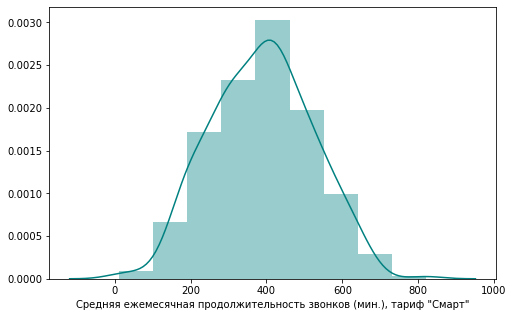

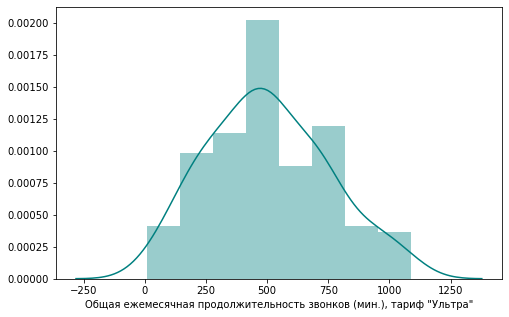

In [53]:
sns.distplot(data_merged_smart
             .monthly_calls_duration,
             bins=bins_count_smart,
             kde=True,
             color="teal",
             norm_hist=True,
             axlabel='Средняя ежемесячная продолжительность звонков (мин.), тариф "Смарт"'
            )

plt.show()

sns.distplot(data_merged_ultra
             .monthly_calls_duration,
             bins=bins_count_ultra,
             kde=True,
             color="teal",
             norm_hist=True,
             axlabel='Общая ежемесячная продолжительность звонков (мин.), тариф "Ультра"'
            )

plt.show()

<b>В выборке пользователей тарифа "Смарт" распределение звонков по общей продолжительности гауссовское со смещением.
        Похожая ситуация и в выборке пользователей тарифа "Ультра". Здесь распределение в большей степени скошено влево.</b>

### Среднее ежемесячное количество сообщений

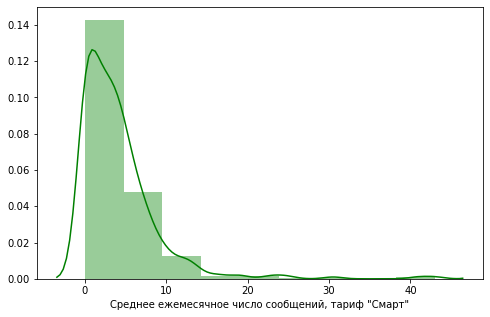

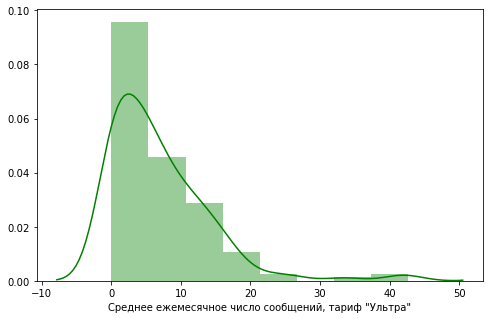

In [54]:
sns.distplot(data_merged_smart
             .monthly_messages_count,
             bins=bins_count_smart,
             kde=True,
             color="green",
             norm_hist=True,
             axlabel='Среднее ежемесячное число сообщений, тариф "Смарт"'
            )

plt.show()

sns.distplot(data_merged_ultra
             .monthly_messages_count,
             bins=bins_count_ultra,
             kde=True,
             color="green",
             norm_hist=True,
             axlabel='Среднее ежемесячное число сообщений, тариф "Ультра"'
            )

plt.show()

**Кривые распределения больше напоминают гауссовы. Очевидно, пользователи тарифа "Smart" крайне редко обмениваются SMS-сообщениями.**

**С приходом социальных сетей и мессенждеров SMS стал постепенно исчезать как вид коммуникации. Полученные гистограммы косвенно об этом свидетельствуют.**

<b>Среди пользователей тарифа "Ultra" SMS более высокую популярность, чем среди пользователей тарифа "Smart".</b>


### Среднее ежемесячное использование интернет-траффика

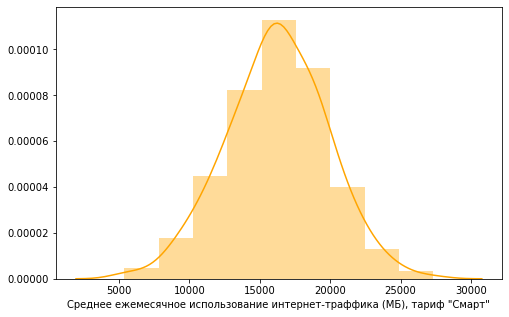

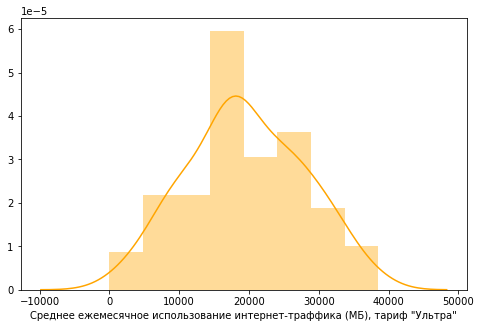

In [55]:
sns.distplot(data_merged_smart
             .monthly_internet_mb,
             bins=bins_count_smart,
             kde=True,
             color="orange",
             norm_hist=True,
             axlabel='Среднее ежемесячное использование интернет-траффика (МБ), тариф "Смарт"'
            )

plt.show()

sns.distplot(data_merged_ultra
             .monthly_internet_mb,
             bins=bins_count_ultra,
             kde=True,
             color="orange",
             norm_hist=True,
             axlabel='Среднее ежемесячное использование интернет-траффика (МБ), тариф "Ультра"'
            )

plt.show()

Формы кривых распределения пользователей тарифа "Смарт" больше напоминают <b>гауссовы</b>.
    
Выделяется весьма "доходная" доля клиентов, использующих большие объёмы интернет-траффика сверх включённого и, таким образом, значительно превышающих средние затраты пользователей тарифа "Ultra".

В выборке, состоящей из пользователей тарифа "Ultra", распределения также больше всего напоминают нормальные <b>гауссовы</b>. <b>Большинство пользователей к окончанию отчётного месяца имеют неизрасходованные мегабайты интернет-трафика</b>.


### Средняя ежемесячная доходность

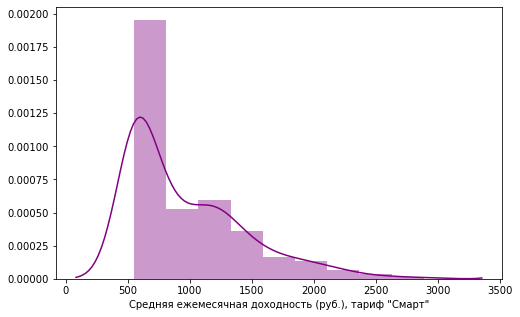

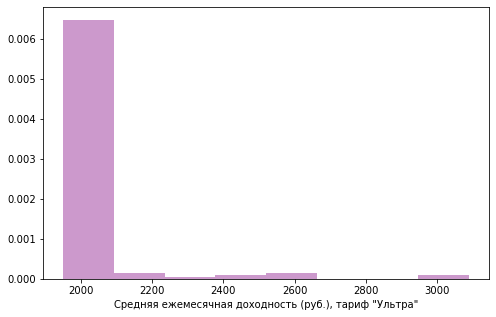

In [56]:
sns.distplot(data_merged_smart
             .monthly_revenue,
             bins=bins_count_smart,
             kde=True,
             color="purple",
             norm_hist=True,
             axlabel='Средняя ежемесячная доходность (руб.), тариф "Смарт"'
            )

plt.show()

sns.distplot(data_merged_ultra
             .monthly_revenue,
             bins=bins_count_ultra,
             kde=True,
             color="purple",
             norm_hist=True,
             axlabel='Средняя ежемесячная доходность (руб.), тариф "Ультра"'
            )

plt.show()

Распределение пользователей тарифа "Smart" по доходности <b>пуассоновское</b>. <b>Основная часть выборки приносит компании меньше 1500 руб. в месяц</b>.

С пользователями "Ultra" всё не так однозначно. Распределения, преимущественно, <b>пуассоновские</b>. <b>Доходность в большинстве случаев не превышает 2000 руб. в месяц</b>.
    
Ежемесячная плата пользователей тарифа "Ультра" почти в четыре раза превышает ежемесячную плату пользователей тарифа "Смарт". Из гистограмм отлично видно, что <b>в выборке пользователей тарифа "Ультра" значительно меньше клиентов, средний ежемесячный платёж которых отличается от "стандартных" 1950 рублей</b>.

## Вывод:

<div style="border: solid darkcyan 2px; padding: 20px">
<b>Пользователям тарифа "Smart", в среднем, требуется 393 минуты, 3 сообщения и 15 ГБ интернет-трафика в месяц.

Пользователям тарифа "Ultra", в среднем, требуется 482 минуты, 5 сообщений и 18 ГБ интернет-трафика в месяц.</b>
</div>

## 4. Проверка гипотез

1. **"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"**.

Исходя из данного пункта, выдвинем **нулевую гипотезу H₀**:

H₀: ***Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"***.

В таком случае, **альтернативная** гипотеза **H₁** будет звучать следующим образом:

H₁: ***Средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт"***.

Для **опровержения одной из двух выдвинутых гипотез** прибегнем к **t-тесту**.

In [57]:
print('Средняя ежемесячная выручка пользователей тарифа "Смарт":',
      rubles_number(data_merged.query('tariff == "smart"')['monthly_revenue'].mean())+';')
print('Средняя ежемесячная выручка пользователей тарифа "Ультра":',
      rubles_number(data_merged.query('tariff == "ultra"')['monthly_revenue'].mean())+'.')

Средняя ежемесячная выручка пользователей тарифа "Смарт": 963 рубля;
Средняя ежемесячная выручка пользователей тарифа "Ультра": 1995 рублей.


In [58]:
interested_value = data_merged.query('tariff == "smart"')['monthly_revenue'].mean()

In [59]:
# Установим критический уровень статистической значимости равным 0,1, ввиду малых размеров выборки:
alpha = 0.1
    
results = st.ttest_1samp(
    data_merged['monthly_revenue'], 
    interested_value)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.215361009014759e-24
Отвергаем нулевую гипотезу


И это логично: средняя ежемесячная выручка пользователей тарифа "Ультра" почти вдвое превышает выручку пользователей тарифа "Смарт".

## Вывод:

В результате t-теста была **отвергнута нулевая гипотеза H₀**.

Средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт", и с высокой долей вероятности полученный результат не является случайным.

Второй пункт звучит следующим образом:

2. **"Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"**

Подготовим данные таким образом, чтобы выборки были разделены по территориальному признаку, введём **2 категории пользователей**: **"Москва"** и **"Другие населённые пункты"**.

Для начала подготовим новые датафреймы, в с которыми будет проще работать:

In [60]:
#Методом .query() создадим выборку пользователей из Москвы:
data_merged_moscow = data_merged.query('city == "Москва"')
data_merged_moscow

,user_id,tariff,activity_months,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue,city
1,1001,smart,2.0,393.500000,16252.500000,0.000000,724.316406,Москва
3,1003,ultra,5.0,702.800000,11465.800000,13.400000,1950.000000,Москва
7,1007,smart,9.0,450.444444,14643.555556,3.111111,550.000000,Москва
31,1031,smart,2.0,570.000000,10555.000000,2.500000,760.000000,Москва
33,1033,smart,6.0,321.000000,20929.000000,11.500000,1637.695312,Москва
...,...,...,...,...,...,...,...,...
447,1453,ultra,12.0,790.750000,23511.333333,5.583333,1950.000000,Москва
455,1461,ultra,2.0,488.500000,17218.500000,6.000000,1950.000000,Москва
469,1476,ultra,8.0,482.125000,18803.625000,0.625000,1950.000000,Москва
474,1481,smart,11.0,269.363636,16875.545455,1.909091,846.004972,Москва


In [61]:
# ... и из других населённых пунктов:
data_merged_other = data_merged.query('city != "Москва"')
data_merged_other

,user_id,tariff,activity_months,monthly_calls_duration,monthly_internet_mb,monthly_messages_count,monthly_revenue,city
0,1000,ultra,8.0,295.375000,13436.500000,9.250000,1950.000000,Краснодар
2,1002,smart,7.0,200.428571,16597.571429,1.428571,791.713170,Стерлитамак
4,1004,ultra,8.0,111.500000,18646.500000,14.375000,1950.000000,Новокузнецк
5,1005,smart,12.0,508.166667,8317.750000,5.083333,574.500000,Набережные Челны
6,1006,smart,11.0,292.090909,14945.000000,0.000000,550.000000,Ульяновск
...,...,...,...,...,...,...,...,...
487,1495,ultra,5.0,717.600000,25507.200000,14.000000,1950.000000,Иркутск
488,1496,smart,12.0,459.333333,22605.750000,3.666667,1965.185547,Вологда
489,1497,smart,3.0,433.333333,15208.666667,4.666667,550.000000,Челябинск
490,1498,smart,4.0,296.750000,18631.500000,8.750000,1188.964844,Владикавказ


Видно, что **объёмы выборок различаются в 4 раза** — москвичей, объективно, меньше, чем жителей других населённых пунктов.

Сформулируем **нулевую гипотезу**:

**H₀: "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов".**

**H₁: "Средние выручки пользователей из Москвы и пользователей из других регионов различны".**

Уровень статистической значимости можем установить на уровне 0,05, так как размеры выборок в тестировании увеличились:

In [62]:
alpha = 0.05

In [63]:
interested_value = data_merged_other['monthly_revenue'].mean()

results = st.ttest_1samp(data_merged_moscow['monthly_revenue'], 
    interested_value)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6071213480491928
Не получилось отвергнуть нулевую гипотезу


## Вывод:

В результате t-теста была **отвергнута альтернативная гипотеза H₁**.

Это говорит о том, что **в рамках нашего исследования среднее выборки пользователей из Москвы с высокой долей вероятности приближённо равно среднему выборки пользователей из других населённых пунктов**.

## 5. Общий вывод

 - В ходе исследования были прочитаны CSV-файлы **"data_calls"**, **"data_internet"**, **"data_messages"**, **"data_tariffs"** и **"data_users"**, был выполнен **поиск дубликатов** и **анализ пропущенных значений**.

 - Данные были приведены к **типам, удобным для работы**.

 - **Проанализированы распределения по месяцам и тарифам**.

 - Получены данные, согласно которым, пользователям тарифа "Smart", в среднем, требуется **356 минут, 1 сообщение и 14 ГБ интернет-трафика в месяц**, а пользователям тарифа "Ultra" — на **77 минут, 1 сообщение и 3 ГБ интернет-трафика больше**.

 - В результате t-теста получены выводы о том, что **средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт"**, и что **среднее выборки пользователей из Москвы с высокой долей вероятности приближённо равно среднему выборки пользователей из других населённых пунктов**.